### 0.0 Introduction

#### This notebook uses data scraped from kickstarter by webrobots (found here : https://webrobots.io/kickstarter-datasets/). Performs an exploratory clustering analysis on these data. It uses word2vec to transform the text data in this set into a 7 dimensional vector.

In [130]:
import requests
import random
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join
import pandas as pd
import ast
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
import numpy as np
import scipy

### 1.0 Importing Data and Selecting Features.

In [131]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [132]:
pd.set_option('display.max_columns', 1000)

In [133]:
month_folders = ['April2023', 'August2023', 'February2023', 'January2022',
                 'January2023', 'July2023', 'June2023', 'March2023', 'May2023', 'September2023'];

In [134]:
raw_df = pd.DataFrame();

current_paths = [];
for month in month_folders:
    current_paths = current_paths + [join(month, x) for x in listdir(month) if '.csv' in x]

for current_path in current_paths:
    df_temp = pd.read_csv(current_path);
    raw_df = pd.concat([raw_df, df_temp])

raw_df = raw_df.reset_index(drop = True)

In [138]:
raw_df.head(1)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,location,name,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,friends,is_backing,is_starred,permissions
0,230,I know how difficult it is to gain any experie...,"{""id"":51,""name"":""Software"",""analytics_name"":""S...",11211.0,GB,the United Kingdom,1389127645,"{""id"":1818855509,""name"":""Marious"",""is_register...",GBP,£,False,USD,1393111179,False,1.238278,1999.0,542567707,False,1390519179,"{""id"":44418,""name"":""London"",""slug"":""london-gb""...",Cisco CCNA and CCNA Security for the Real Worl...,"{""key"":""assets/011/631/975/49f72198be90d30752b...",6746.0,"{""id"":839405,""project_id"":839405,""state"":""inac...",cisco-ccna-and-ccna-security-for-the-real-worl...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1393111180,1.648362,"{""web"":{""project"":""https://www.kickstarter.com...",1.661914,11119.847421,international,NaN,NaN,NaN,NaN


In [136]:
df_selected = raw_df[['backers_count', 'blurb',
                      'category', 'country', 'creator',
                      'currency', 'currency_trailing_code',
                      'disable_communication', 'fx_rate',
                      'goal', 'is_starrable', 'name',
                      'pledged', 'slug', 'spotlight',
                      'staff_pick', 'state', 'usd_exchange_rate',
                      'usd_pledged']]

In [139]:
df_selected.loc[:,'category'] = (df_selected.copy()).apply(lambda x : ast.literal_eval(x['category'])['name'], axis = 1)

In [140]:
df_selected.head(1)

,backers_count,blurb,category,country,creator,currency,currency_trailing_code,disable_communication,fx_rate,goal,is_starrable,name,pledged,slug,spotlight,staff_pick,state,usd_exchange_rate,usd_pledged
0,230,I know how difficult it is to gain any experie...,Software,GB,"{""id"":1818855509,""name"":""Marious"",""is_register...",GBP,False,False,1.238278,1999.0,False,Cisco CCNA and CCNA Security for the Real Worl...,6746.0,cisco-ccna-and-ccna-security-for-the-real-worl...,True,False,successful,1.661914,11119.847421


### 2.0 Word Embedding

##### I am going to create a corpus from the, "name," "slug," and "blub" text fields. Concatenating thiese strings together for each entry will make a sentence for each data point which I will then append into a list that will represent my word corpus.

In [141]:
corpus = [];
corpus_index = []

for index, row in df_selected.iterrows():
    try:
        sentence = [row['name'] + '. ' + row['slug'] + '. ' + row['blurb']];
        corpus = corpus + sentence;
        corpus_index.append(index);
    
    except:
        continue;

##### I am going to keep a record of each sentence and the corresponding data index in a data frame calld df_corpus.

In [142]:
df_corpus = pd.DataFrame({'sentences' : corpus}, index = corpus_index)

##### Now I will use simple_preprocess from gensim.utils to cast the corpus in to a standard format that word2vec can use and then train the model.

In [143]:
corpus_preprocessed = [simple_preprocess(i) for i in corpus]

In [144]:
model = Word2Vec(corpus_preprocessed, min_count = 1, vector_size = 7)

##### Now that the model is trained I will make lookup table called df_high_dimensional_vocab that will keep a record of each 7 dimensional vector, represented by the columns [t, u, v, w, x, y, z], and the word that it corresponds to. 

In [145]:
vocabulary = []
for index, word in enumerate(model.wv.index_to_key):
    vocabulary = vocabulary + [{'t' : list(model.wv[word])[0],
                                'u' : list(model.wv[word])[1],
                                'v' : list(model.wv[word])[2], 
                                'w' : list(model.wv[word])[3], 
                                'x' : list(model.wv[word])[4],
                                'y' : list(model.wv[word])[5],
                                'z' : list(model.wv[word])[6],
                                'word' : word}]

In [146]:
df_high_dimension_vocab = pd.DataFrame(vocabulary).set_index('word', drop = True)

#### 2.1 Plotting a PCA-reduced version of the data

##### As a small sanity check I am going to reduce the dimension of the corpus-vector space using PCA and plot the distribution of points.

In [219]:
wv_reduced = PCA(n_components = 2)
wv_reduced.fit(df_high_dimension_vocab[['t', 'u', 'v', 'w', 'x', 'y', 'z']])
reduced_vocab_vectors = wv_reduced.transform(df_high_dimension_vocab[['t', 'u', 'v', 'w', 'x', 'y', 'z']])

In [220]:
df_reduced_vocab = pd.DataFrame({'x': list(reduced_vocab_vectors[:, 0]), 
                                 'y': list(reduced_vocab_vectors[:, 1]),
                                 'word' : df_high_dimension_vocab.index})

<Axes: xlabel='x', ylabel='y'>

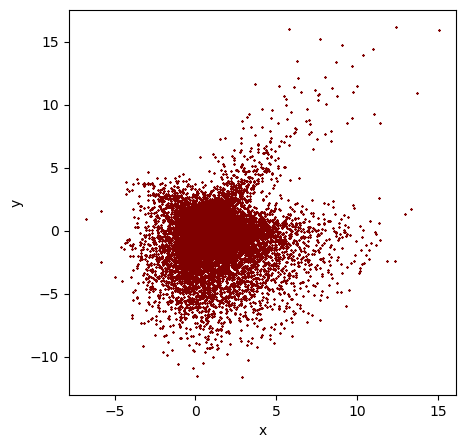

In [221]:
df_reduced_vocab.plot.scatter(x = 'x', y = 'y', s = 1, marker = 'x', figsize = (5, 5), color = [[0.5, 0.0, 0.0]])

##### It definitly looks like there is some complex structure in higher dimensions, which is good.

### 3.0 Clustering

In [222]:
df_w_sentences = pd.concat([df_selected[['backers_count',
                                         'category',
                                         'fx_rate',
                                         'goal',
                                         'pledged',
                                         'state']].loc[df_corpus.index],df_corpus], axis = 1)

In [223]:
df_w_sentences[['t', 'u', 'v', 'w', 'x', 'y', 'z']] = np.nan

In [224]:
df_w_sentences.head(2)

,backers_count,category,fx_rate,goal,pledged,state,sentences,t,u,v,w,x,y,z
0,230,Software,1.238278,1999.0,6746.0,successful,Cisco CCNA and CCNA Security for the Real Worl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34,Software,1.238278,200.0,1079.0,successful,Strong File Encryption Tool. strong-file-encry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
def sentence_median(sentence_string):
    processed_sentence = simple_preprocess(sentence_string);
    sentence_list = [];
    sentence_median = 7*[np.nan];
    for word in processed_sentence:
        try:      
            sentence_list.append(df_high_dimension_vocab.loc[word])
        except:
            break;
            
    sentence_array = np.array(sentence_list)
    return np.median(sentence_array, axis = 0)

In [226]:
error_index = []
for index, row in df_w_sentences.iterrows():
    try:
        df_w_sentences.loc[index, ['t', 'u', 'v', 'w', 'x', 'y', 'z']] = sentence_median(row['sentences'])
    except:
        error_index.append(index)

/home/jason/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jason/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [50]:
df_w_sentences.head(2)

,backers_count,category,fx_rate,goal,pledged,state,sentences,t,u,v,w,x,y,z,goal_usd,pledged_usd
0,230,Software,1.238278,1999.0,6746.0,successful,Cisco CCNA and CCNA Security for the Real Worl...,-0.614744,-1.362357,1.256272,2.776866,0.758209,-3.470245,0.106088,2475.318022,8353.424400
1,34,Software,1.238278,200.0,1079.0,successful,Strong File Encryption Tool. strong-file-encry...,0.849055,-2.193782,-0.047758,3.997278,0.735483,-0.739189,1.670300,247.655630,1336.102124


In [26]:
df_w_sentences['goal_usd'] = df_w_sentences['goal'] * df_w_sentences['fx_rate']

In [27]:
df_w_sentences['pledged_usd'] = df_w_sentences['pledged'] * df_w_sentences['fx_rate']

In [28]:
df_cluster = df_w_sentences[['category', 'state','backers_count', 'goal_usd', 'pledged_usd','t', 'u', 'v', 'w', 'x', 'y', 'z']]

In [29]:
def map_state_to_number(state_string):
    lookup = {"failed": -3.0,
              "canceled": -2.0,
              "suspended" : -1.0,
              "submitted" : 0.0,
              "started" : 1.0,
              "live" : 2.0,
              "successful" : 3.0};
    try:
        value = lookup[state_string];
    except:
        value = np.nan;
        
    return value;

In [42]:
category_lookup = {}
for index, item in enumerate(list(set(df_w_sentences['category']))):
    category_lookup.update({item: index})

In [44]:
def map_category_to_number(state_string, category_lookup):
    try:
        value = category_lookup[state_string];
    except:
        value = -1.1;
    
    return value

In [35]:
df_cluster_copy = df_cluster.copy()

In [36]:
df_cluster_copy.columns

Index(['category', 'state', 'backers_count', 'goal_usd', 'pledged_usd', 't',
       'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='object')

In [37]:
df_cluster_copy['state'] = df_cluster['state'].apply(lambda x : map_state_to_number(x))

In [45]:
df_cluster_copy['category'] = df_cluster['category'].apply(lambda x : map_category_to_number(x, category_lookup))

array([[<Axes: title={'center': 'state'}>]], dtype=object)

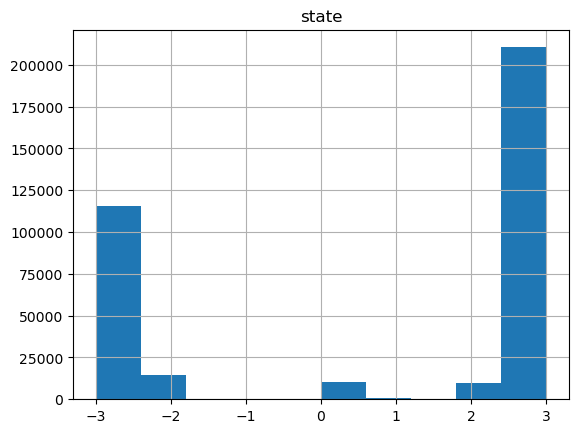

In [39]:
df_cluster_copy.hist(column = 'state', grid = True)

array([[<Axes: title={'center': 'category'}>]], dtype=object)

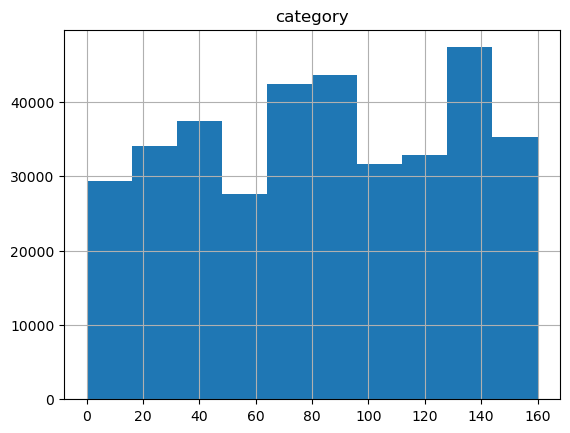

In [46]:
df_cluster_copy.hist(column = 'category', grid = True)

In [47]:
df_cluster_copy.to_csv("./kickstarter_numerical_clustering_dataset.csv", index = False)

In [48]:
df_cluster_copy.head()

,category,state,backers_count,goal_usd,pledged_usd,t,u,v,w,x,y,z
0,79,3.0,230,2475.318022,8353.424400,-0.614744,-1.362357,1.256272,2.776866,0.758209,-3.470245,0.106088
1,79,3.0,34,247.655630,1336.102124,0.849055,-2.193782,-0.047758,3.997278,0.735483,-0.739189,1.670300
2,79,3.0,226,10000.000000,17451.000000,0.089434,-2.562426,-0.719220,3.136730,0.998678,-2.530694,1.012942
3,79,3.0,655,50000.000000,51309.830000,-1.801973,-3.125506,1.132509,4.232285,1.994624,-2.952389,-0.026714
4,79,3.0,24,123.772180,301.385258,-0.002953,-3.250757,-2.425439,4.620069,2.635032,-1.965134,1.229133


In [101]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
df_cluster = pd.read_csv('./kickstarter_numerical_clustering_dataset.csv')

#### 3.1 Cleaning

##### I am going to drop any rows with nan.

In [3]:
df_cluster = df_cluster.dropna(axis = 0)

In [90]:
def silhouette_plot(silhouette_values, silhouette_average, labels):
    
    fig, ax = plt.subplots();
    fig.set_size_inches(6,6);
    
    ax.set_xlim([-0.1, 1.0]);
    ax.set_ylim([0, len(silhouette_values) + (len(set(labels)) + 1) * 10])
    
    cluster_plot_lower_y_value = 10;
    for label_value in list(set(labels)):
        label_n_silhouette_values = sorted([silhouette_values[i] for i in range(len(labels)) if labels[i] == label_value]);
        
        size_of_n_cluster = len(label_n_silhouette_values);
        cluster_plot_upper_y_value = cluster_plot_lower_y_value + size_of_n_cluster
        
        color = cm.nipy_spectral(float(label_value/len(set(labels))));
        plt.fill_betweenx(np.arange(cluster_plot_lower_y_value, cluster_plot_upper_y_value),
                          0,
                          label_n_silhouette_values,
                          facecolor = color,
                          edgecolor = color,
                          alpha = 0.7)
        
        ax.text(-0.05, cluster_plot_lower_y_value + 0.5*size_of_n_cluster, str(label_value));        
        cluster_plot_lower_y_value = cluster_plot_upper_y_value + 10;              
        
    ax.axvline(x=silhouette_average, color = "red", linestyle = "--");

    ax.set_yticks([]);
    ax.set_xticks([-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]);

    ax.set_ylabel("cluster assignment", rotation = 45, horizontalalignment = 'right')
    ax.set_xlabel("silhouette score");
    ax.set_title("silhoutte plot for {} clusters".format(len(set(labels))));
                                                    
    return fig, ax    

In [5]:
def scale_data(df_in):
    
    scaler = StandardScaler();
    
    transformed_data = scaler.fit_transform(df_in.values)
    df_transformed = pd.DataFrame(columns = df_in.columns,
                                  data = transformed_data,
                                  index = df_in.index);
    
    return df_transformed;

In [6]:
def k_means_processing(df_in, n_clusters):
    
    kmeans = KMeans(n_clusters = n_clusters, n_init = 'auto')
    
    model = kmeans.fit(df_in);
    cluster_labels = model.predict(df_in);
    
    silhouette_average = silhouette_score(df_in, cluster_labels);
    silhouette_values = list(silhouette_samples(df_in, cluster_labels).flatten());
    
    df_in.loc[:,'labels_' + str(n_clusters) + '_clusters'] = cluster_labels;
    
    return df_in, model, cluster_labels, silhouette_values, silhouette_average

#### 3.1 K-means Fitting

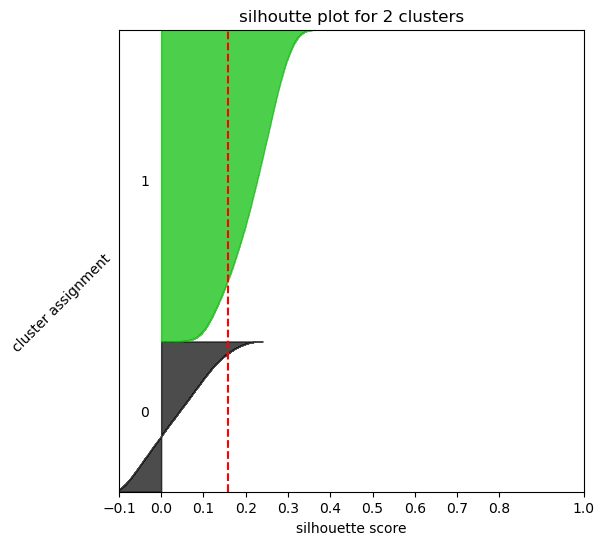

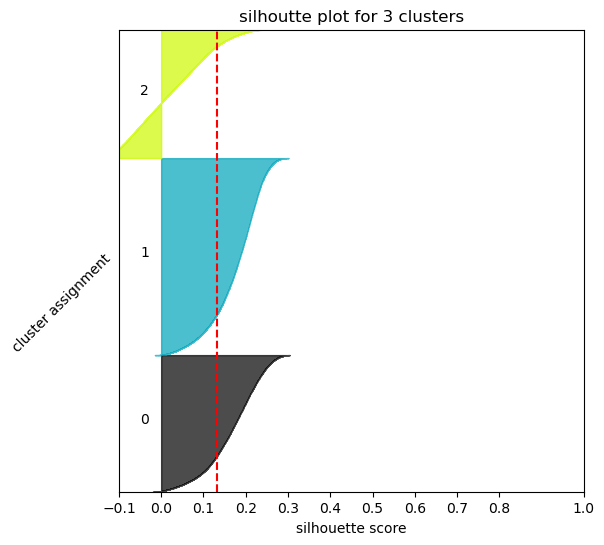

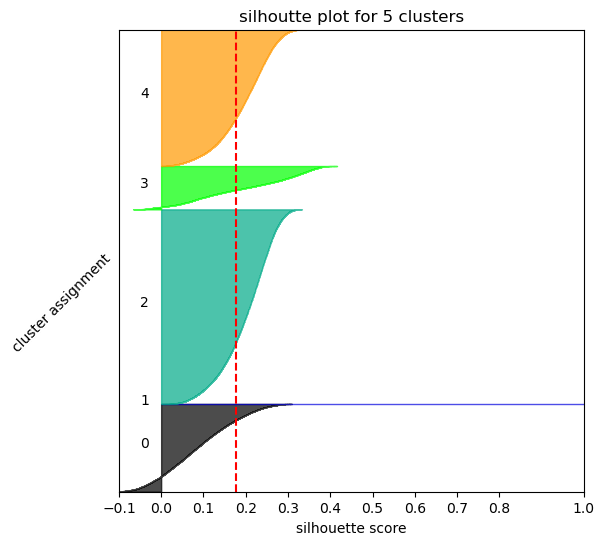

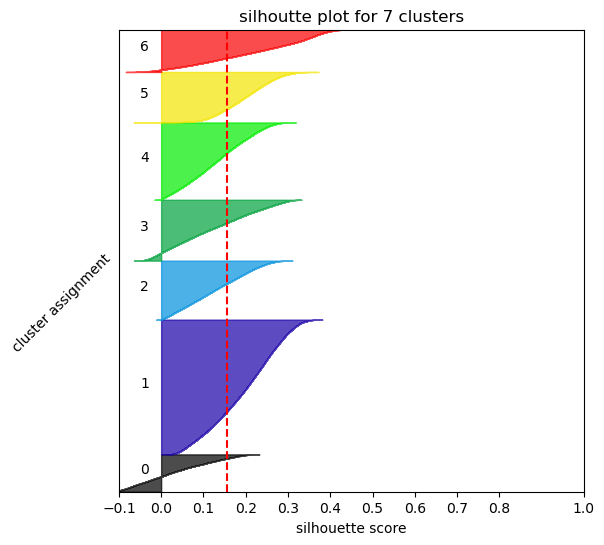

In [109]:
data_dict = {}
number_clusters_to_try = [2, 3, 5, 7]
df_cluster_scaled = scale_data(df_cluster)
for number_clusters in number_clusters_to_try:
    df_cluster_labeled, kmeans_model, cluster_labels, silhouette_values, silhouette_average = k_means_processing(df_cluster_scaled, number_clusters)
    
    data_dict.update({number_clusters : df_cluster_labeled})
    
    joblib.dump(data_dict, './clustering_results.pickle')
    
    silhouette_plot(silhouette_values, silhouette_average, cluster_labels)

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'silhoutte plot for 6 clusters'}, xlabel='silhouette score', ylabel='cluster assignment'>)

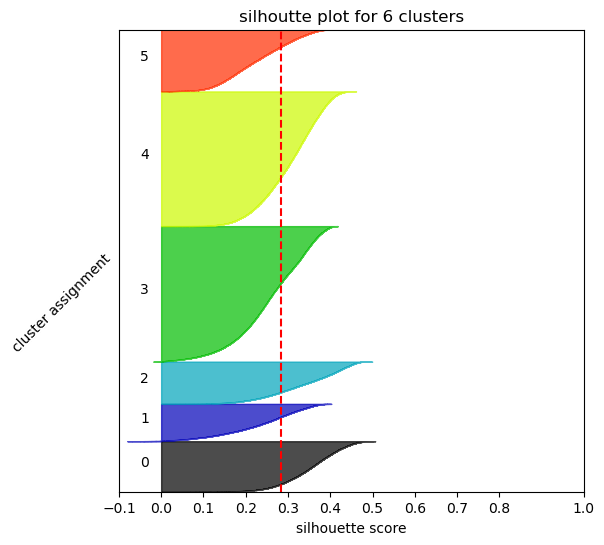

In [110]:
df_cluster_labeled, kmeans_model, cluster_labels, silhouette_values, silhouette_average = k_means_processing(df_cluster_scaled, 6)
    
data_dict.update({number_clusters : df_cluster_labeled})
    
joblib.dump(data_dict, './clustering_results.pickle')
    
silhouette_plot(silhouette_values, silhouette_average, cluster_labels)

In [114]:
df_6_clusters = df_cluster;

In [124]:
df_6_clusters.loc[:, 'labels_6_clusters'] = df_cluster_labeled['labels_6_clusters']

In [127]:
df_6_clusters.to_csv('./labled_cluster_data_with_6_clusters.csv', index = False)

In [374]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,labels_6_clusters,median_data_point_word,median_cluster_word
0,Gadgets,successful,230,2475.318022,8353.424400,4,peaceful,myrrh
1,Gadgets,successful,34,247.655630,1336.102124,1,suitable,mindful
2,Gadgets,successful,226,10000.000000,17451.000000,1,ginza,mindful
3,Gadgets,successful,655,50000.000000,51309.830000,1,busy,mindful
4,Gadgets,successful,24,123.772180,301.385258,1,shadowkey,mindful


#### 3.1 Median Words

##### I am going to use the word vector features to assign the word that corresponds to the 7 dimensional embedding vector for each data point AND then also assign the word that corresponds to the median vector for all of the data points in each cluster.

In [ ]:
df_6_clusters.loc[:, 'median_data_point_word'] = df_6_clusters.apply(lambda x : model.wv.most_similar(x[['t', 'u', 'v', 'w', 'x', 'y', 'z']].values, topn = 1), axis = 1)

In [176]:
df_6_clusters.loc[:, 'median_data_point_word'] = df_6_clusters['median_data_point_word'].apply(lambda x : x[0][0])

In [373]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,labels_6_clusters,median_data_point_word,median_cluster_word
0,Gadgets,successful,230,2475.318022,8353.424400,4,peaceful,myrrh
1,Gadgets,successful,34,247.655630,1336.102124,1,suitable,mindful
2,Gadgets,successful,226,10000.000000,17451.000000,1,ginza,mindful
3,Gadgets,successful,655,50000.000000,51309.830000,1,busy,mindful
4,Gadgets,successful,24,123.772180,301.385258,1,shadowkey,mindful


In [203]:
def median_cluster_word(df_in, label_column_name):
    clusters = sorted(set(df_in[label_column_name]));
    median_value = {};
    for cluster_number in clusters:
        median_value.update({cluster_number : {'vector' : df_in.loc[df_in[label_column_name] == cluster_number,['t', 'u', 'v', 'w', 'x', 'y', 'z']].median().values,
                                              'word' : np.nan}});
    
    for cluster_number in median_value:
        median_value[cluster_number]['word'] = model.wv.most_similar(positive = median_value[cluster_number]['vector'], topn = 1)[0][0];
        
    return median_value;

In [204]:
median_cluster_words = median_cluster_word(df_6_clusters, 'labels_6_clusters')

In [207]:
df_6_clusters['median_cluster_word'] = ""

In [208]:
for key in median_cluster_words:
    df_6_clusters.loc[df_6_clusters['labels_6_clusters'] == key, 'median_cluster_word'] = median_cluster_words[key]['word']

In [209]:
df_6_clusters.loc[df_6_clusters['labels_6_clusters'] == 3, 'median_cluster_word'] = median_cluster_words[3]['word']

In [211]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,t,u,v,w,x,y,z,labels_6_clusters,median_data_point_word,median_cluster_word
0,79,3.0,230,2475.318022,8353.424400,-0.614744,-1.362357,1.256272,2.776866,0.758209,-3.470245,0.106088,4,peaceful,myrrh
1,79,3.0,34,247.655630,1336.102124,0.849055,-2.193782,-0.047758,3.997278,0.735483,-0.739189,1.670300,1,suitable,mindful
2,79,3.0,226,10000.000000,17451.000000,0.089434,-2.562426,-0.719220,3.136730,0.998678,-2.530694,1.012942,1,ginza,mindful
3,79,3.0,655,50000.000000,51309.830000,-1.801973,-3.125506,1.132509,4.232285,1.994624,-2.952389,-0.026714,1,busy,mindful
4,79,3.0,24,123.772180,301.385258,-0.002953,-3.250757,-2.425439,4.620069,2.635032,-1.965134,1.229133,1,shadowkey,mindful


#### 3.3 Translating numbers back to strings

##### Now that the vectors have been translated back into words I am going to remove the [t, u, v, w, x, y, z] embedding features.

In [213]:
df_6_clusters.drop(['t', 'u', 'v', 'w', 'x', 'y', 'z'], axis = 1, inplace = True)

In [372]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,labels_6_clusters,median_data_point_word,median_cluster_word
0,Gadgets,successful,230,2475.318022,8353.424400,4,peaceful,myrrh
1,Gadgets,successful,34,247.655630,1336.102124,1,suitable,mindful
2,Gadgets,successful,226,10000.000000,17451.000000,1,ginza,mindful
3,Gadgets,successful,655,50000.000000,51309.830000,1,busy,mindful
4,Gadgets,successful,24,123.772180,301.385258,1,shadowkey,mindful


##### I will also translate the category and state numbers back into their string values

In [217]:
def map_number_to_state(state_string):
    lookup = {-3.0 : "failed",
              -2.0 : "canceled",
              -1.0 : "suspended",
               0.0 : "submitted",
               1.0 : "started", 
               2.0 : "live",
               3.0 : "successful"};
    try:
        value = lookup[state_string];
    except:
        value = np.nan;
        
    return value;

In [231]:
reverse_category_lookup = {}
for index, item in enumerate(list(set(df_w_sentences['category']))):
    reverse_category_lookup.update({index: item})

In [228]:
def map_number_to_category(state_number, reverse_category_lookup):
    try:
        value = reverse_category_lookup[state_number];
    except:
        value = 'missing'
    
    return value

In [233]:
df_6_clusters.loc[:, 'state'] = df_6_clusters['state'].apply(lambda x : map_number_to_state(x));

In [234]:
df_6_clusters.loc[:, 'category'] = df_6_clusters['category'].apply(lambda x : map_number_to_category(x, reverse_category_lookup))

In [371]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,labels_6_clusters,median_data_point_word,median_cluster_word
0,Gadgets,successful,230,2475.318022,8353.424400,4,peaceful,myrrh
1,Gadgets,successful,34,247.655630,1336.102124,1,suitable,mindful
2,Gadgets,successful,226,10000.000000,17451.000000,1,ginza,mindful
3,Gadgets,successful,655,50000.000000,51309.830000,1,busy,mindful
4,Gadgets,successful,24,123.772180,301.385258,1,shadowkey,mindful


In [237]:
df_6_clusters.to_csv('./analysis_ready_6_cluster_data.csv', index = False)

### 4.0 Analysis

#### 4.1 Exploration

##### Now the data are partitioned (with the clustering algorithm) and the langage data has been incorporated into that partitioning in a ration way, I will reimport the data under a different variable name and complete the exploratory analysis.

In [244]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [239]:
df_analysis = pd.read_csv('./analysis_ready_6_cluster_data.csv')

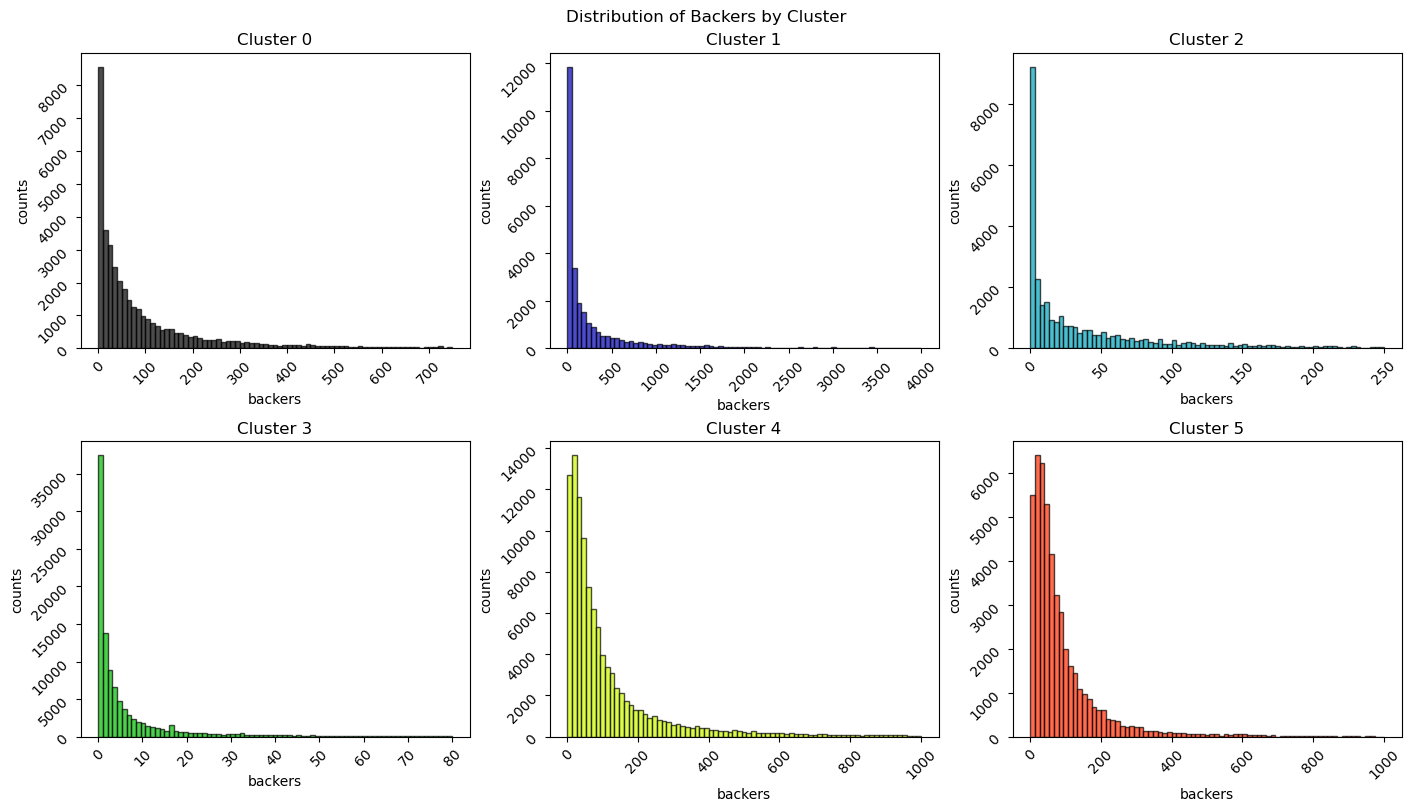

In [391]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of Backers by Cluster")

backer_x_lims = [750, 4000, 250, 80, 1000, 1000]
backer_y_lims = [6e3, 1.25e4, 1e4, 4.5e4, 1.5e4, 7e3]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_6_clusters.loc[df_6_clusters['labels_6_clusters'] == index , :]
    hist_data = hist_data.loc[hist_data['backers_count'] <= backer_x_lims[index], 'backers_count'].values
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}'.format(index))
    ax.set_xlabel('backers')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)

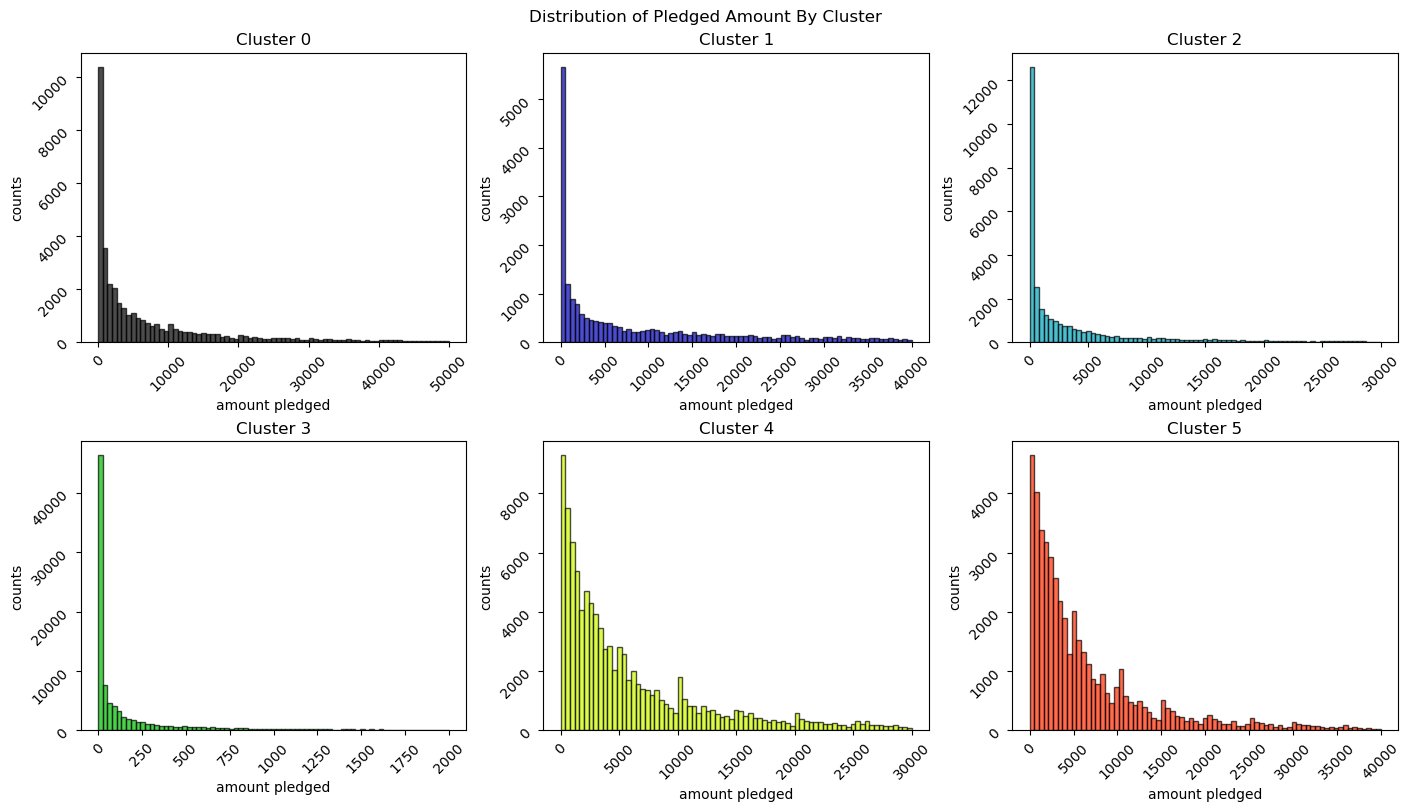

In [363]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of Pledged Amount By Cluster")

pledged_x_lims = [5e4, 4e4, 3e4, 2e3, 3e4, 4e4]
pledged_y_lims = [1.25e4, 6e3, 1.5e4, 5e4, 1e4, 5e3]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_6_clusters.loc[df_6_clusters['labels_6_clusters'] == index , :]
    hist_data = hist_data.loc[hist_data['pledged_usd'] <= pledged_x_lims[index], 'pledged_usd'].values
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}'.format(index))
    ax.set_xlabel('amount pledged')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)

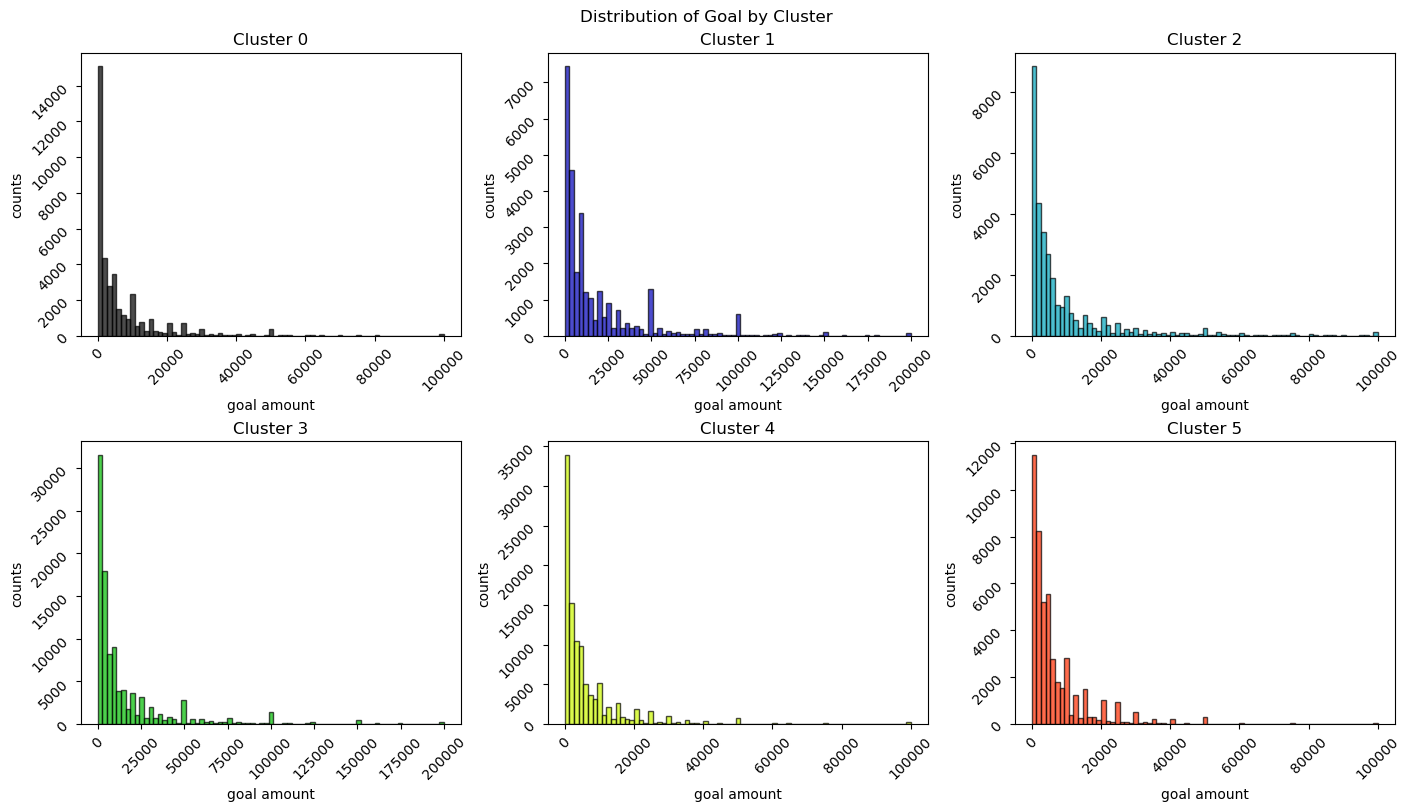

In [369]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of Goal by Cluster")

pledged_x_lims = [1e5, 2e5, 1e5, 2e5, 1e5, 1e5]
pledged_y_lims = [1.25e4, 6e3, 1.5e4, 5e4, 1e4, 5e3]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_6_clusters.loc[df_6_clusters['labels_6_clusters'] == index , :]
    hist_data = hist_data.loc[hist_data['goal_usd'] <= pledged_x_lims[index], 'goal_usd'].values
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}'.format(index))
    ax.set_xlabel('goal amount')
    ax.set_ylabel('counts')
    #ax.set_xlim([0, pledged_x_lims[index]])    
    #ax.set_ylim([0, pledged_y_lims[index]])
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)

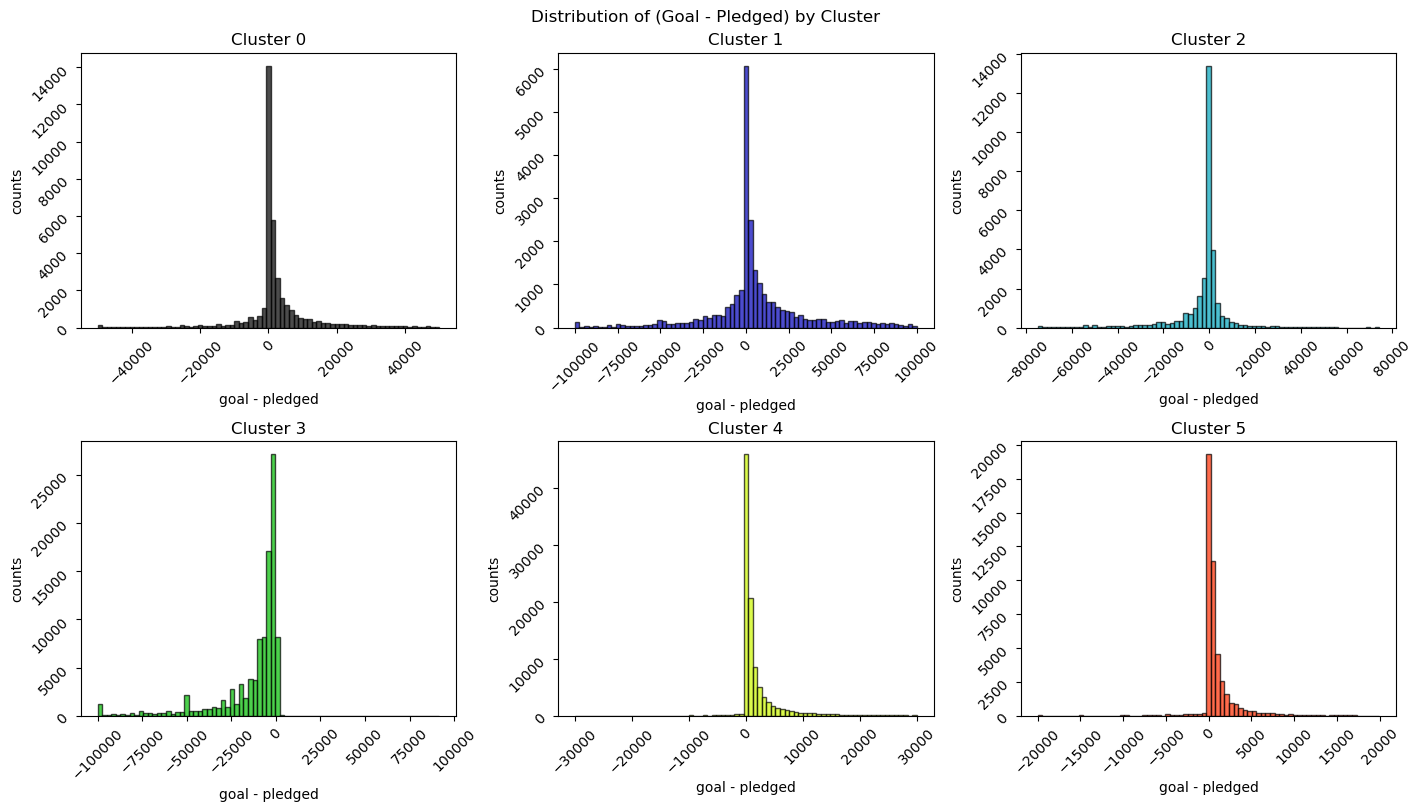

In [403]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of (Goal - Pledged) by Cluster")

difference_absolute_maxima = [5e4, 1e5, 7.5e4, 1e5, 3e4, 2e4]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):  
    df_temp = df_6_clusters.copy()
    df_temp = df_temp.loc[df_temp['labels_6_clusters'] == index, :]
    df_temp['difference'] = np.nan;
    df_temp.loc[:, 'difference'] = df_temp.apply(lambda x : x['pledged_usd'] - x['goal_usd'], axis = 1)
    df_temp = df_temp.loc[(df_temp['difference'] >= -difference_absolute_maxima[index]) & (df_temp['difference'] <= difference_absolute_maxima[index]), :]
                      
    hist_data = df_temp['difference'].values
        
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}'.format(index))
    ax.set_xlabel('goal - pledged')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)

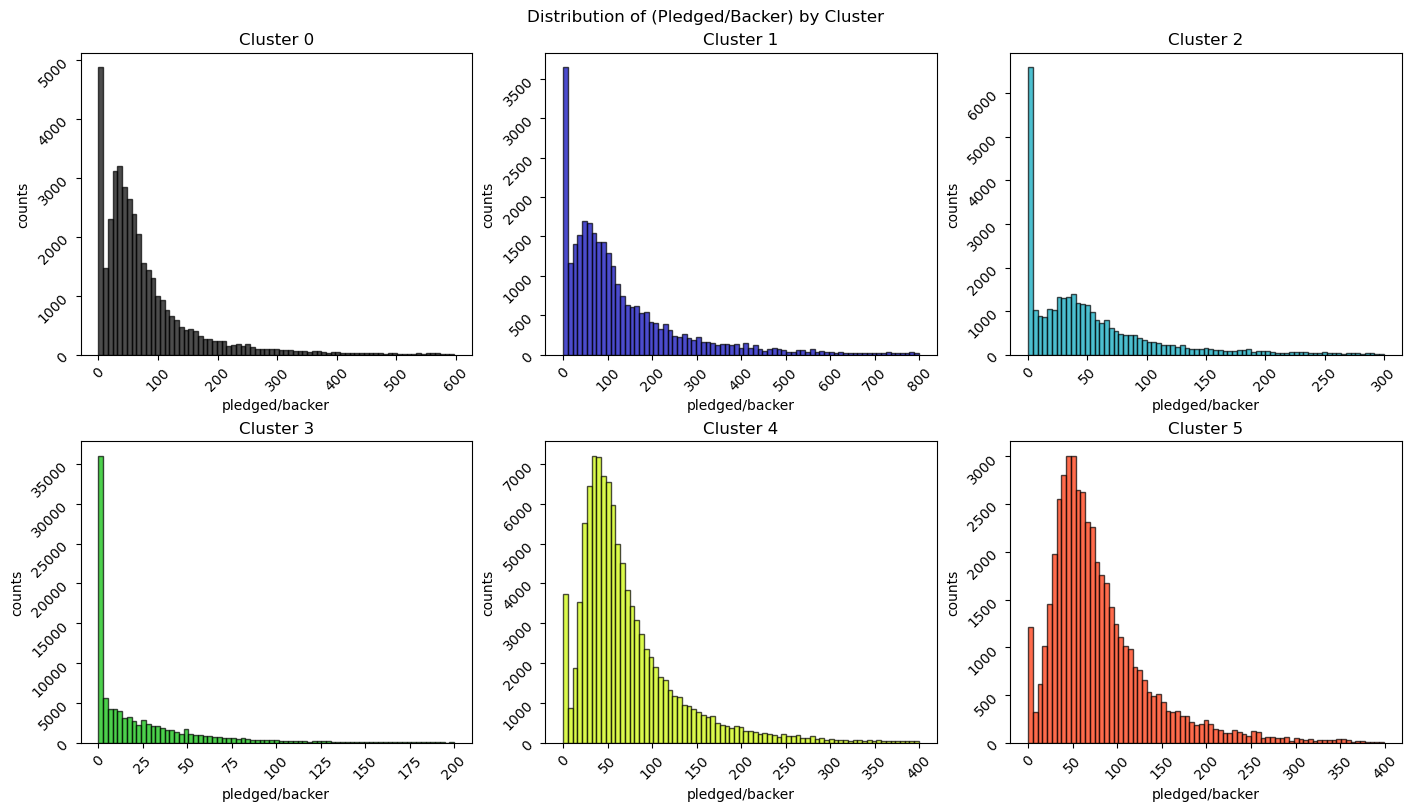

In [400]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of (Pledged/Backer) by Cluster")

difference_absolute_maxima = [6e2, 8e2, 3e2, 2e2, 4e2, 4e2]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):  
    df_temp = df_6_clusters.copy()
    df_temp = df_temp.loc[df_temp['labels_6_clusters'] == index, :]
    df_temp['difference'] = np.nan;
    df_temp.loc[:, 'difference'] = df_temp.apply(lambda x : x['pledged_usd']/(x['backers_count']+1), axis = 1)
    df_temp = df_temp.loc[(df_temp['difference'] >= -difference_absolute_maxima[index]) & (df_temp['difference'] <= difference_absolute_maxima[index]), :]
                      
    hist_data = df_temp['difference'].values
        
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}'.format(index))
    ax.set_xlabel('pledged/backer')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)

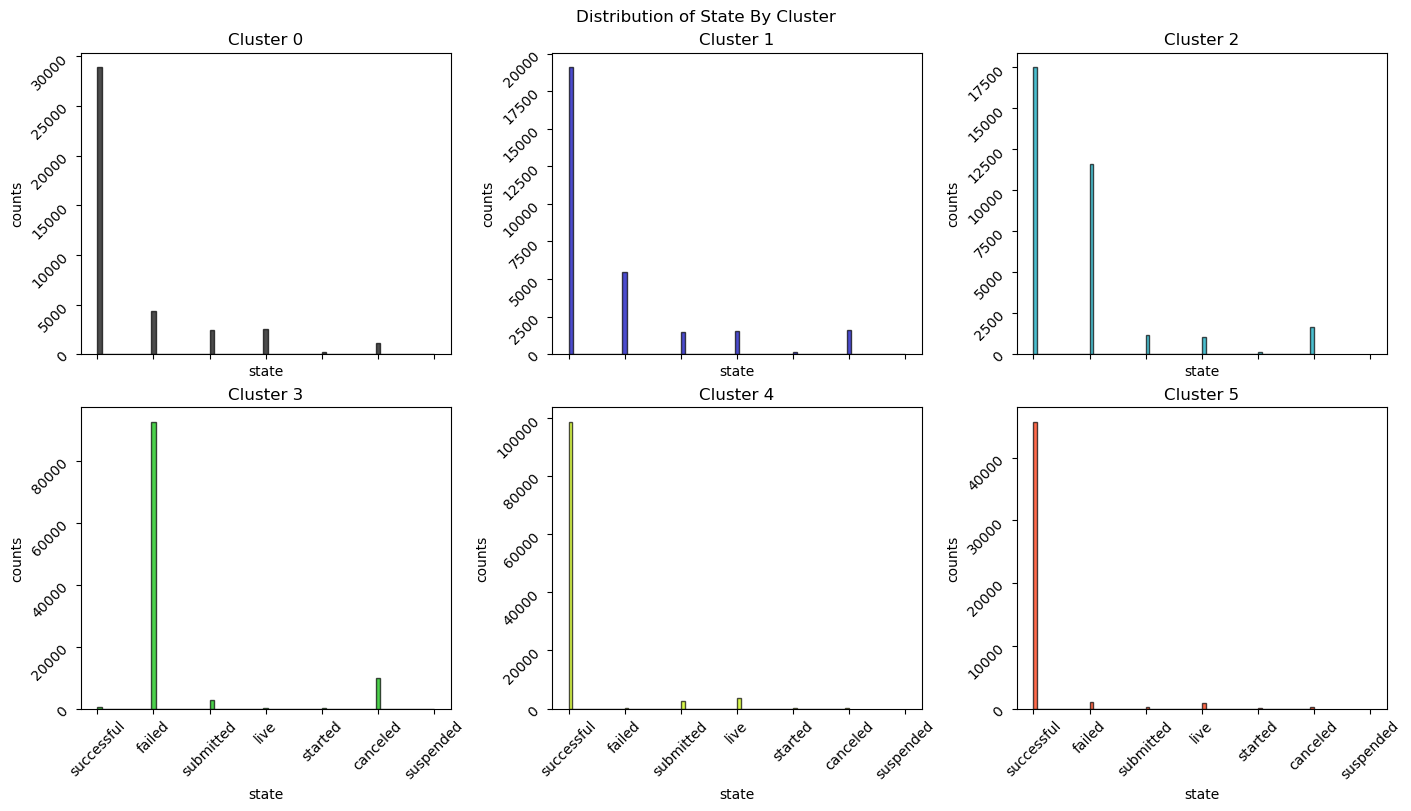

In [404]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, sharex = True, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of State By Cluster")

pledged_x_lims = [5e4, 4e4, 3e4, 2e3, 3e4, 4e4]
pledged_y_lims = [1.25e4, 6e3, 1.5e4, 5e4, 1e4, 5e3]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_6_clusters.loc[df_6_clusters['labels_6_clusters'] == index , :]
    hist_data = hist_data.loc[:, 'state'].values
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}'.format(index))
    ax.set_xlabel('state')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)